In [1]:
import numpy as np
from collections import defaultdict
from scipy.spatial import distance

def generate_data(n_samples=100, centers=3, seed=42):
    np.random.seed(seed)
    data = []
    for i in range(centers):
        center = np.random.uniform(-5, 5, size=2)
        points = center + np.random.randn(n_samples // centers, 2)
        data.extend(points)
    return np.array(data)

SNN-кластеризация (Shared Nearest Neighbor)

In [2]:
# поиск k ближайших соседей для каждой точки
def knn_graph(X, k):
    neighbors = []
    for i in range(len(X)):
        dists = [distance.euclidean(X[i], X[j]) for j in range(len(X))]
        knn = np.argsort(dists)[1:k+1]  # исключаем саму точку
        neighbors.append(set(knn))
    return neighbors

# вычисление количества общих соседей для каждой пары
def shared_neighbors(neighbors):
    snn_matrix = np.zeros((len(neighbors), len(neighbors)), dtype=int)
    for i in range(len(neighbors)):
        for j in range(i+1, len(neighbors)):
            shared = len(neighbors[i].intersection(neighbors[j]))
            snn_matrix[i][j] = shared
            snn_matrix[j][i] = shared
    return snn_matrix

# кластеризация на основе порога сходства
def snn_clustering(snn_matrix, eps=3, min_pts=5):
    visited = set()                 # сюда сохраняем точки, которые уже проанализировали
    labels = [-1] * len(snn_matrix) # метки кластеров ((-1) - либо ещё никуда не отнесли, либо шум)
    cluster_id = 0                  # кол-во кластеров

    for i in range(len(snn_matrix)):
        if i in visited:
            continue
        visited.add(i)
        neighbors = [j for j in range(len(snn_matrix)) if snn_matrix[i][j] >= eps]
        if len(neighbors) < min_pts:
            labels[i] = -1  # отбрасываем точки с недостаточным количеством соседей для создания кластера
        else:
            labels[i] = cluster_id
            queue = neighbors.copy()
            while queue:
                j = queue.pop()
                if j not in visited:
                    visited.add(j)
                    j_neighbors = [k for k in range(len(snn_matrix)) if snn_matrix[j][k] >= eps]
                    if len(j_neighbors) >= min_pts:
                        queue.extend(j_neighbors)
                if labels[j] == -1:
                    labels[j] = cluster_id
            cluster_id += 1
    return labels

Так выглядит neighbors после применения knn_graph (каждое подмножество - это точка и её связь с ближайшими двумя вершинами)

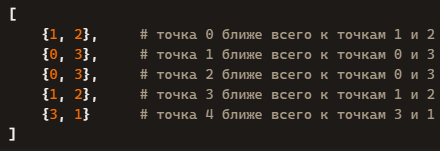

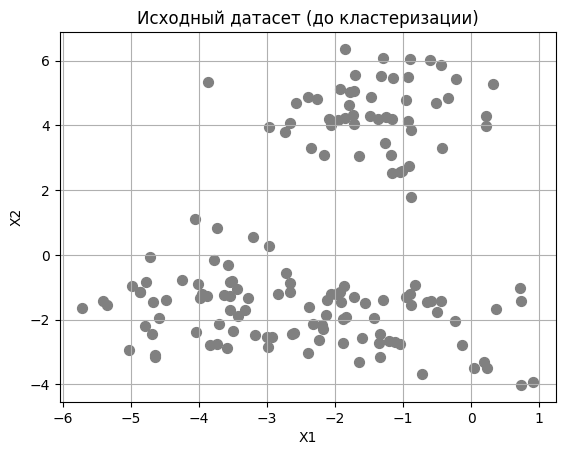

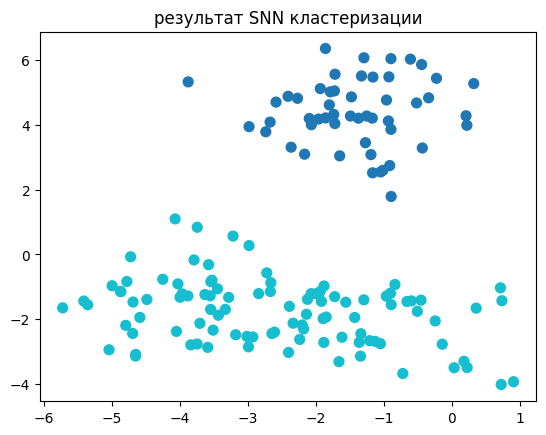

In [4]:
import matplotlib.pyplot as plt

X = generate_data(n_samples=150, centers=3)
plt.scatter(X[:, 0], X[:, 1], c='gray', s=50)
plt.title("Исходный датасет (до кластеризации)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.show()

neighbors = knn_graph(X, k=10)
snn_matrix = shared_neighbors(neighbors)
labels = snn_clustering(snn_matrix, eps=3, min_pts=5)

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', s=50)
plt.title("результат SNN кластеризации")
plt.show()

In [6]:
neighbors = knn_graph(X, k=10)
snn_matrix = shared_neighbors(neighbors)
labels = snn_clustering(snn_matrix, eps=3, min_pts=5)

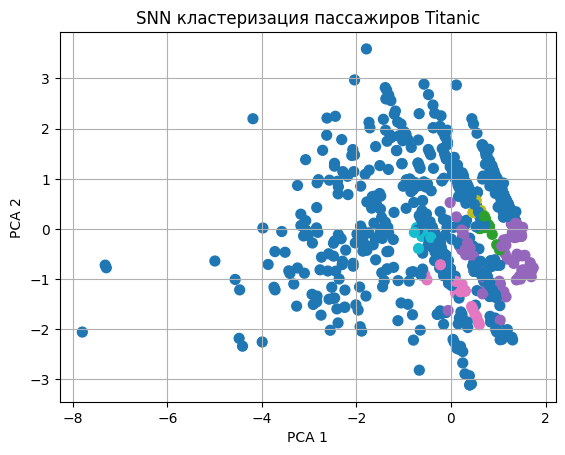

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=50)
plt.title("SNN кластеризация пассажиров Titanic")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

In [8]:
df['Cluster'] = labels
cluster_summary = df.groupby('Cluster').mean()
print(cluster_summary)


           Pclass       Sex        Age       Fare  Embarked
Cluster                                                    
0        2.110457  0.589102  31.498895  37.383835  1.653903
1        3.000000  1.000000  28.409091  10.092297  1.000000
2        2.991935  1.000000  18.781613  13.883402  1.258065
3        2.942857  0.000000  26.585714  10.424529  1.000000
4        3.000000  1.000000  28.545455  61.242782  2.000000
5        2.000000  1.000000  29.166667  24.134256  0.000000


In [9]:
df_with_survival = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
df_with_survival['Cluster'] = labels
survival_by_cluster = df_with_survival.groupby('Cluster')['Survived'].mean()
print(survival_by_cluster)


Cluster
0    0.418262
1    0.090909
2    0.185484
3    0.742857
4    0.454545
5    0.111111
Name: Survived, dtype: float64


| Кластер | Выживаемость | Комментарий |
|---------|--------------|-------------|
| 0       | 41.8%        | Смешанный кластер: мужчины и женщины 2 класса, средние по стоимости билеты |
| 1       | 9.1%         | Мужчины 3 класса, дешёвые билеты — одна из самых уязвимых групп |
| 2       | 18.5%        | Молодые мужчины 3 класса — также плохо выживали |
| 3       | 74.3%        | Женщины 3 класса — подтверждает правило "женщины и дети первыми" |
| 4       | 45.5%        | Мужчины 3 класса с дорогими билетами — возможно, семьи или группы, которым повезло больше, чем одиноким мужчинам |
| 5       | 11.1%        | Мужчины 2 класса — чуть лучше, чем 3 класс, но всё ещё уязвимы |
